Data Wrangling

In [2]:
# Imports
import glob
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import random

import kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Sequential

import shutil

import pandas as pd
from collections import Counter

2025-01-25 02:01:50.190818: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 02:01:50.315384: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 02:01:50.412610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737770510.531491     858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737770510.549544     858 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 02:01:50.749413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Data Download

In [3]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


2. Data re-structuring

Right now, the data exists in a set of numbered directories, one for each patient. In each patient directory there are two sub-directories 0 and 1 containing IDC negative and IDC positive images. We need to collect all of the IDC negative images and IDC positive images into their own directories.

In [4]:
# Get a list of patient directories
patients=glob.glob(f'{path}/*')

# Set up target directories for file copy
idc_negative_directory='../data/idc_negative/'
idc_positive_directory='../data/idc_positive/'

Path(idc_negative_directory).mkdir(parents=True, exist_ok=True)
Path(idc_positive_directory).mkdir(parents=True, exist_ok=True)

# Loop on the patient directories and copy the '0' images to
# the idc_negative directory and the '1' images to the
# idc_positive directory
for patient in patients:

    # Copy the idc negative images from this patient
    idc_negative_images=glob.glob(f'{patient}/0/*.png')

    for image in idc_negative_images:
        shutil.copy(image, idc_negative_directory)

    # Copy the idc positive images from this patient
    idc_positive_images=glob.glob(f'{patient}/1/*.png')

    for image in idc_positive_images:
        shutil.copy(image, idc_positive_directory)

In [5]:
# Step 1b: Data Sampling for Efficiency
sampled_negative_directory = '../data_sampled/idc_negative/'
sampled_positive_directory = '../data_sampled/idc_positive/'

# Create directories for sampled data
Path(sampled_negative_directory).mkdir(parents=True, exist_ok=True)
Path(sampled_positive_directory).mkdir(parents=True, exist_ok=True)

# Sampling parameters
sample_size = 100  # Adjust as needed

In [6]:
# Function to sample and copy images
def sample_images(source_dir, target_dir, sample_size):
    images = glob.glob(f'{source_dir}/*.png')
    sampled_images = random.sample(images, min(sample_size, len(images)))
    for image in sampled_images:
        shutil.copy(image, target_dir)

In [7]:
# Sample negative and positive images
sample_images(idc_negative_directory, sampled_negative_directory, sample_size)
sample_images(idc_positive_directory, sampled_positive_directory, sample_size)

print("Sampling complete!")

Sampling complete!


EDA

In [8]:
idc_negative_count = len(glob.glob(f'{idc_negative_directory}/*.png'))
idc_positive_count = len(glob.glob(f'{idc_positive_directory}/*.png'))

print(f"IDC Negative Images: {idc_negative_count}")
print(f"IDC Positive Images: {idc_positive_count}")

IDC Negative Images: 198738
IDC Positive Images: 78786


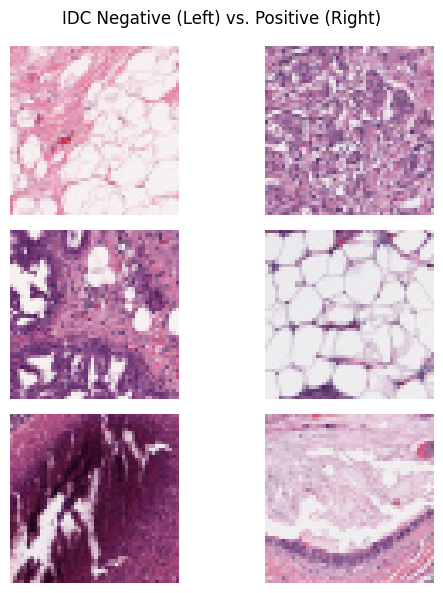

In [9]:
from tensorflow.keras.preprocessing import image

# Visualize IDC Negative and Positive Images Side-by-Side
negative_images = glob.glob(f'{idc_negative_directory}/*.png')[:3]
positive_images = glob.glob(f'{idc_positive_directory}/*.png')[:3]

fig, axs = plt.subplots(3, 2, figsize=(6, 6))  # Adjusted figsize for clarity
for neg_img, pos_img, row in zip(negative_images, positive_images, axs):
    for img_path, ax in zip([neg_img, pos_img], row):
        img = image.load_img(img_path)
        img = image.img_to_array(img)
        img /= 255.0  # Normalize image values
        ax.imshow(img)
        ax.axis('off')

plt.suptitle("IDC Negative (Left) vs. Positive (Right)")
plt.tight_layout()
plt.show()

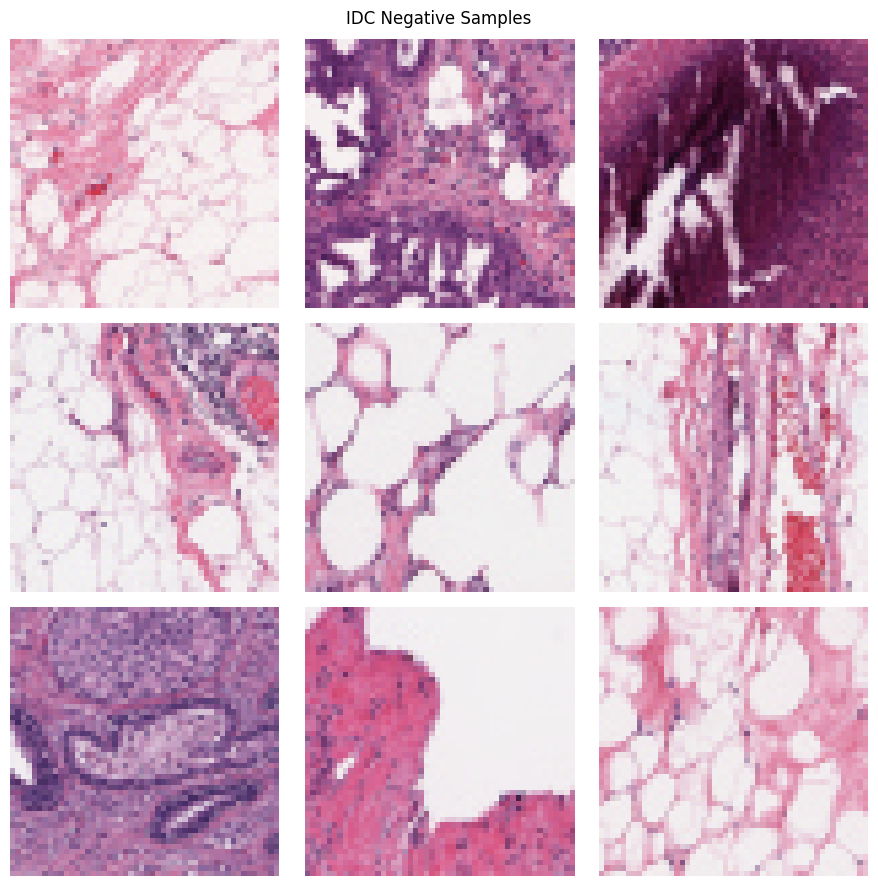

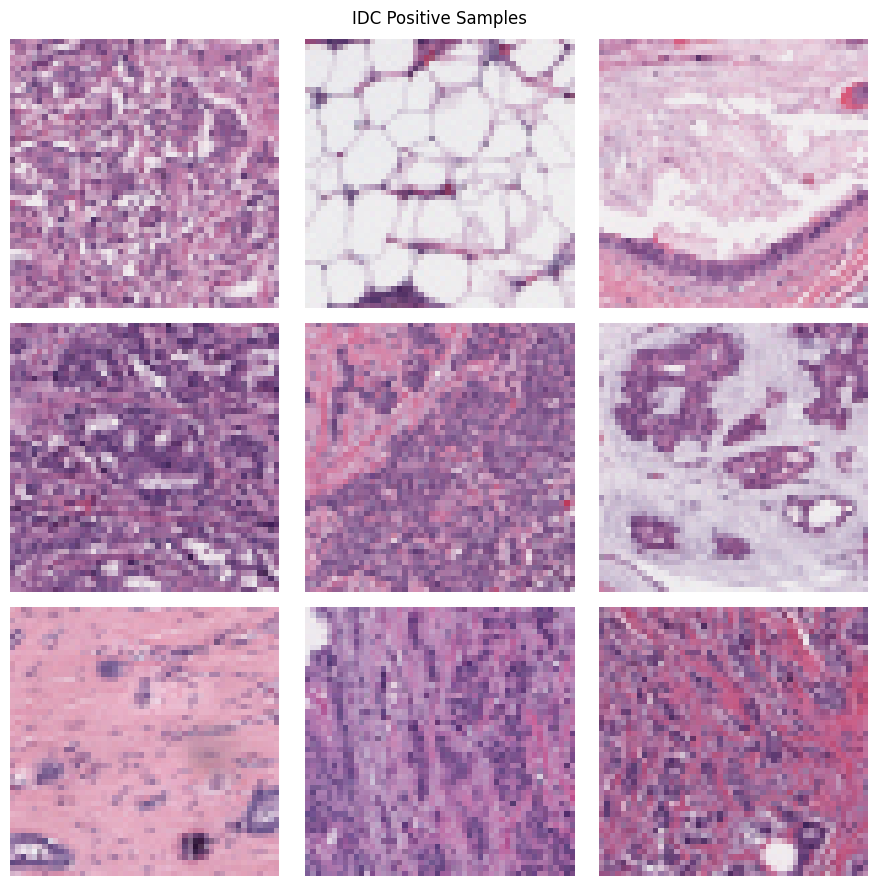

In [10]:
def plot_sample_images(directory, title, num_images=9):
    images = glob.glob(f"{directory}/*.png")
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axs.flat[:min(num_images, len(images))]):
        img = plt.imread(images[i])
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_sample_images(idc_negative_directory, "IDC Negative Samples")
plot_sample_images(idc_positive_directory, "IDC Positive Samples")

In [11]:
data_summary = pd.DataFrame({
    "Class": ["IDC Negative", "IDC Positive"],
    "Image Count": [idc_negative_count, idc_positive_count]
})
print(data_summary)

          Class  Image Count
0  IDC Negative       198738
1  IDC Positive        78786


In [12]:
# Check for class imbalance
total_images = idc_negative_count + idc_positive_count
print(f"Class Distribution:\n{data_summary}")
print(f"IDC Negative: {idc_negative_count / total_images:.2%}, IDC Positive: {idc_positive_count / total_images:.2%}")
if abs(idc_negative_count - idc_positive_count) / total_images > 0.2:
    print("Warning: Potential class imbalance detected.")

Class Distribution:
          Class  Image Count
0  IDC Negative       198738
1  IDC Positive        78786
IDC Negative: 71.61%, IDC Positive: 28.39%


Prepare Image Dataset

In [13]:
def make_datasets(training_data_path: str, image_dim: int, batch_size: int=32):
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    )
    return training_dataset, validation_dataset

image_dim = 128
batch_size = 32
training_dataset, validation_dataset = make_datasets('../data/', image_dim, batch_size)

Found 277524 files belonging to 2 classes.
Using 222020 files for training.


2025-01-25 02:14:50.965235: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 277524 files belonging to 2 classes.
Using 55504 files for validation.


In [14]:
training_dataset = training_dataset.take(100)
validation_dataset = validation_dataset.take(50)

Sample Model

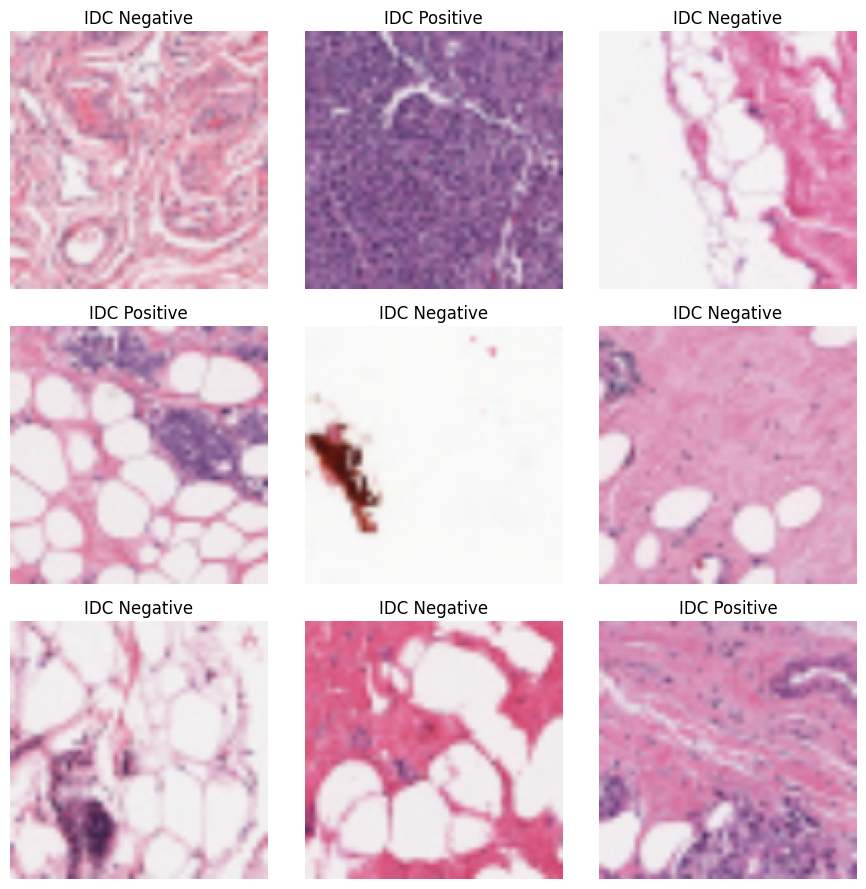

In [15]:
def visualize_images(dataset, class_names):
    images, labels = next(iter(dataset))
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axs.flat[:images.shape[0]]):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[int(labels[i])])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['IDC Negative', 'IDC Positive']
visualize_images(training_dataset, class_names)

define the model

In [16]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_dim, image_dim, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the model

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Train the model

In [18]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=10,
    steps_per_epoch=len(training_dataset),
    validation_steps=len(validation_dataset)
) 

Epoch 1/10


2025-01-25 02:19:10.632804: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2025-01-25 02:19:11.836007: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


  1/100 ━━━━━━━━━━━━━━━━━━━━ 4:24 3s/step - accuracy: 0.6562 - loss: 4.2761

2025-01-25 02:19:12.080458: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


  2/100 ━━━━━━━━━━━━━━━━━━━━ 1:05 672ms/step - accuracy: 0.6719 - loss: 71.1572

2025-01-25 02:19:12.582202: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2025-01-25 02:19:12.750937: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 659ms/step - accuracy: 0.6472 - loss: 20.4903 - val_accuracy: 0.7300 - val_loss: 0.6744
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 638ms/step - accuracy: 0.7061 - loss: 0.6787 - val_accuracy: 0.7300 - val_loss: 0.6065
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 627ms/step - accuracy: 0.7108 - loss: 0.6255 - val_accuracy: 0.7331 - val_loss: 0.5885
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 637ms/step - accuracy: 0.7045 - loss: 0.6309 - val_accuracy: 0.7300 - val_loss: 0.5880
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 641ms/step - accuracy: 0.7083 - loss: 0.6066 - val_accuracy: 0.7244 - val_loss: 0.5902
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 648ms/step - accuracy: 0.7033 - loss: 0.6079 - val_accuracy: 0.7244 - val_loss: 0.5908
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 629ms/step - accuracy: 0.7106 - loss: 0.6027 - val_accuracy: 0.7281 - val_loss: 0.5864
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 639ms/step - accuracy: 0.7124 - loss: 0.6016 - va

Evaluate the model

In [19]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.7227 - loss: 0.5915
Validation Loss: 0.5844, Validation Accuracy: 0.7312


Training History

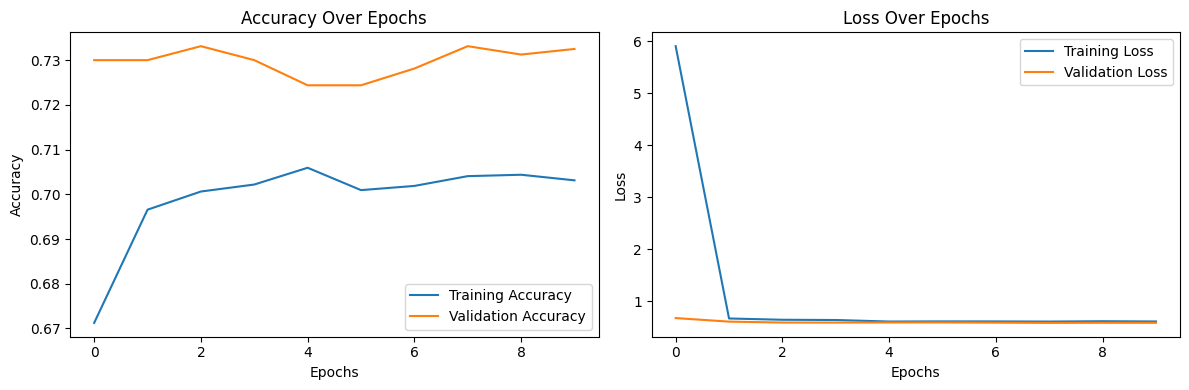

In [20]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.tight_layout()
    plt.show()

plot_training_history(history)